In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import torch.utils.data as data
import lightning.pytorch as pl
from lightning.pytorch.utilities.model_summary import ModelSummary

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of sequences
N = 100
# Max sequence length
M = 60
t_max = 10
t_min = 2
# Process noise
pn = 0.5
# Measurement noise
mn = 0.3
b = 0.01

# 1 dim for x, 1 dim for t
input_dim = 2
hidden_dim = 16
latent_dim = 4
mlp_layers = 3
enc_layers = 3
dec_layers = 3

# Will need to be 1 for how handling RNN later
n_epochs = 50
batch_size = 1

# HPs
beta = 0.1
lr=1e-4

In [3]:
np.random.seed(42)

In [4]:
tspan = np.linspace(t_min, t_max, M)

In [5]:
# Growth function
def g(x, b, t, pn):
    eps_p = np.random.normal(scale=pn, size=x.shape[0])
    return x + b * x + np.cos(np.pi * t) + eps_p

In [6]:
# Z is the latent variable
z0 = np.random.normal(size=N)
Z = np.zeros((N, M))
Z[:, 0] = z0
for m in range(M):
    Z[:, m] = g(Z[:, m-1], b, tspan[m], pn)

In [7]:
eps_m = np.random.normal(scale=mn, size=Z.shape)
X = Z + eps_m

In [8]:
Z = torch.tensor(Z, dtype=torch.float32)
X = torch.tensor(X, dtype=torch.float32)
tspan = torch.tensor(tspan, dtype=torch.float32)

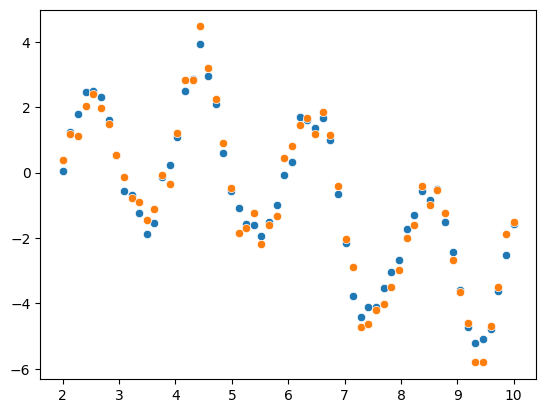

In [9]:
sns.scatterplot(x = tspan, y = Z[10])
sns.scatterplot(x = tspan, y = X[10])
# sns.scatterplot(x = tspan, y = np.cos(np.pi * tspan))
plt.show()

In [10]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_fn=F.relu):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.activation_fn = activation_fn

        self.layers = nn.ModuleList()
        for i in range(self.num_layers - 1):
            prev_dim = self.input_dim if i == 0 else self.hidden_dim
            self.layers.append(nn.Linear(prev_dim, self.hidden_dim))
           
        penult_dim = self.input_dim if num_layers == 1 else self.hidden_dim
        self.final_layer = nn.Linear(penult_dim, self.output_dim)

    def forward(self, x):
        for i in range(self.num_layers - 1):
            x = self.activation_fn(self.layers[i](x))
        return self.final_layer(x)

In [11]:
# TODO:
# (2) Swap RNN #2 for a Neural DE
class LitVAE(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, latent_dim, enc_layers, dec_layers, activation_fn=F.relu, criterion=nn.MSELoss(), lr=1e-3, beta=1.0, reverse=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.activation_fn = activation_fn
        self.criterion = criterion
        self.lr = lr
        self.beta = beta
        # Encode input in reverse order
        self.reverse = reverse

        self.encoder = nn.GRU(self.input_dim, self.hidden_dim, num_layers=self.enc_layers, batch_first=True)
        self.enc2mean = nn.Linear(self.hidden_dim, self.latent_dim)
        self.enc2logvar = nn.Linear(self.hidden_dim, self.latent_dim)
        # Exclude time dimension
        self.latent2out = nn.Linear(self.latent_dim, self.input_dim - 1)
        # Include time dimension
        self.decoder = nn.GRU(self.input_dim, self.hidden_dim, num_layers=self.enc_layers, batch_first=True)
        # Exclude time dimension
        self.hidden2out = nn.Linear(self.hidden_dim, self.input_dim - 1)

    def forward(self, x, tspan_q):
        # tspan_q is the query tspan (tspan for decoding)
        # since you may want decoding for held-out data, times
        # that were unobserved
        _, _, _, x_dec = self._forward(x, tspan_q)
        return x_dec
    
    def training_step(self, batch, batch_idx):
        x, tspan_q = batch
        
        mean_z, logvar_z, z, x_dec = self._forward(x, tspan_q.squeeze(0))
        
        # Allow for more complex priors
        mean_prior = torch.zeros_like(mean_z)
        logvar_prior = torch.zeros_like(logvar_z)

        loss_recon = self.criterion(x_dec, x)
        loss_kl = self._kl_div(mean_z, logvar_z, mean_prior, logvar_prior)
        loss = loss_recon + self.beta * loss_kl
        self.log("train_recon_loss", loss_recon, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_kl_loss", loss_kl, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.lr, amsgrad=True)
        
    def _forward(self, x, tspan_q):
        # Output will be of size (batch_size, seq_len, inp_size)
        # Only grab the last output
        # x_enc, h = self.encoder(x)
        # x_enc = x_enc[:, -1, :]

        x_fwd = x.flip(dims=[1]) if self.reverse else x
        _, h = self.encoder(x_fwd)
        x_enc = h[-1]

        # Compute latent parameters and sample
        mean_z = self.enc2mean(x_enc)
        logvar_z = self.enc2logvar(x_enc)
        z = self._reparam(mean_z, logvar_z)

        # Get starting hidden state for decoding
        # Hidden state shape is (n_layers, batch_size, hidden_dim)
        h = torch.zeros(self.dec_layers, x.shape[0], self.hidden_dim).to(self.device)

        # Destination for decoded x, since t dimension is included in input
        # dimensions, subtract 1 (we aren't predicting t_q since it's input)
        x_dec = torch.zeros(x.shape[0], tspan_q.shape[0], self.input_dim - 1).to(self.device)
        
        # Decode z into data space, include a sequence dimension
        x_z = self.latent2out(z)[:, None, :]
        
        for i, t in enumerate(tspan_q):
            # Concatenate t with x_z
            # Need to broadcast t from shape () to shape (batch_size, 1, 1)
            xt_z = torch.concat((x_z, t[None, None, None].expand(x_z.shape[0], -1, -1)), dim=-1)
            
            # Predict output for tspan_q[i]
            x_dec_t, h = self.decoder(xt_z, h)
            x_dec_t = self.hidden2out(x_dec_t.squeeze(1))
            x_dec[:, i, :] = x_dec_t
            
            # Use predicted output as next input
            x_z = x_dec_t.unsqueeze(0)
            
        return mean_z, logvar_z, z, x_dec

    def _reparam(self, mean, logvar):
        sd = torch.exp(0.5 * logvar)
        eps = torch.randn_like(sd)
        return mean + eps * sd

    def _kl_div(self, mean, logvar, mean_prior, logvar_prior):
        kl_div = 0.5 * (logvar_prior - logvar + (torch.exp(logvar) + (mean - mean_prior)**2) / torch.exp(logvar_prior) - 1)
        return kl_div.sum(dim=-1)

In [12]:
X_ = X[:, :, None]
tspan_ = tspan[None, :, None].expand(X_.shape[0], -1, -1)
tspan_q = tspan.expand(X_.shape[0], -1)
Y = torch.cat((X_, tspan_), dim=2)

In [13]:
n_train = int(N * 0.8)
n_val = int(N - n_train)

In [14]:
# train_dataset = data.TensorDataset(Y[:n_train])
train_dataset = data.TensorDataset(Y[:n_train], tspan_q[:n_train])
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
for i, batch in enumerate(train_loader):
    if i == 0:
        break

In [16]:
x, tspan_q = batch

In [17]:
print(x.shape)
print(tspan_q.shape)

torch.Size([1, 60, 2])
torch.Size([1, 60])


In [18]:
tspan_q.squeeze(0).shape

torch.Size([60])

In [19]:
# 1 fewer encoder layer, since have extra enc -> mean & enc -> logvar layers
model = LitVAE(input_dim, hidden_dim, latent_dim, enc_layers, dec_layers, activation_fn=F.elu, beta=beta, reverse=True)

In [20]:
model(batch[0], torch.tensor([1.0, 1.1, 1.2]))

tensor([[[0.1683],
         [0.2054],
         [0.2267]]], grad_fn=<CopySlices>)

In [21]:
ModelSummary(model)

  | Name       | Type    | Params
---------------------------------------
0 | criterion  | MSELoss | 0     
1 | encoder    | GRU     | 4.2 K 
2 | enc2mean   | Linear  | 68    
3 | enc2logvar | Linear  | 68    
4 | latent2out | Linear  | 5     
5 | decoder    | GRU     | 4.2 K 
6 | hidden2out | Linear  | 17    
---------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)

In [22]:
model

LitVAE(
  (criterion): MSELoss()
  (encoder): GRU(2, 16, num_layers=3, batch_first=True)
  (enc2mean): Linear(in_features=16, out_features=4, bias=True)
  (enc2logvar): Linear(in_features=16, out_features=4, bias=True)
  (latent2out): Linear(in_features=4, out_features=1, bias=True)
  (decoder): GRU(2, 16, num_layers=3, batch_first=True)
  (hidden2out): Linear(in_features=16, out_features=1, bias=True)
)

In [23]:
accelerator = "gpu" if device.type == "cuda" else "cpu"

In [24]:
trainer_dev = pl.Trainer(accelerator=accelerator, fast_dev_run=1)
trainer_dev.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | criterion  | MSELoss | 0     
1 | encoder    | GRU     | 4.2 K 
2 | enc2mean   | Linear  | 68    
3 | enc2logvar | Linear  | 68    
4 | latent2out | Linear  | 5     
5 | decoder    | GRU     | 4.2 K 
6 | hidden2out | Linear  | 17    
---------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
/home/carcook/anaconda3/envs/torchdyn-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have man

Training: 0it [00:00, ?it/s]

/home/carcook/anaconda3/envs/torchdyn-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 60, 2])) that is different to the input size (torch.Size([1, 60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_steps=1` reached.


In [26]:
model = LitVAE(input_dim, hidden_dim, latent_dim, enc_layers, dec_layers, activation_fn=F.elu, beta=beta, reverse=False)
trainer = pl.Trainer(
    accelerator=accelerator,
    max_epochs=n_epochs,
    gradient_clip_algorithm="norm",
    gradient_clip_val=1.0,
    # callbacks=[RichProgressBar()],
    default_root_dir="lightning_logs_ode_rnn"
)
trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | criterion  | MSELoss | 0     
1 | encoder    | GRU     | 4.2 K 
2 | enc2mean   | Linear  | 68    
3 | enc2logvar | Linear  | 68    
4 | latent2out | Linear  | 5     
5 | decoder    | GRU     | 4.2 K 
6 | hidden2out | Linear  | 17    
---------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]